In [1]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os
import gzip
import numpy as np
import scanpy as sc
import squidpy as sq
import cupy as cp
import cupyx
from cupyx.scipy.sparse import csr_matrix 
import os
import time
import rapids_singlecell as rsc
import numpy as np
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
import cupy

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)
import zarr
import pickle
from collections import OrderedDict
from scipy.sparse import csr_matrix
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from scipy.sparse import csr_matrix
import scipy
from anndata import AnnData
from collections import OrderedDict
from rsc_functions.utility.applyqc import applyqc
from rsc_functions.reports.plot import plot_spatial,plot_spatial_data, plot_dist
from rsc_functions.utility.rank_genes_groups import return_markers,rank_genes_groups
from rsc_functions.reports.plot import plot_expression

In [2]:
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/R_simulation"
counts = pd.read_csv(os.path.join(pathout,'Rsim_count.csv'))
adata = AnnData(counts.iloc[:,1:].to_numpy(), obsm={"spatial": pd.read_csv(os.path.join(pathout,'Rsim_centroids.csv')).loc[:,['x','y']].to_numpy()})

In [3]:
adata

AnnData object with n_obs × n_vars = 3611 × 80
    obsm: 'spatial'

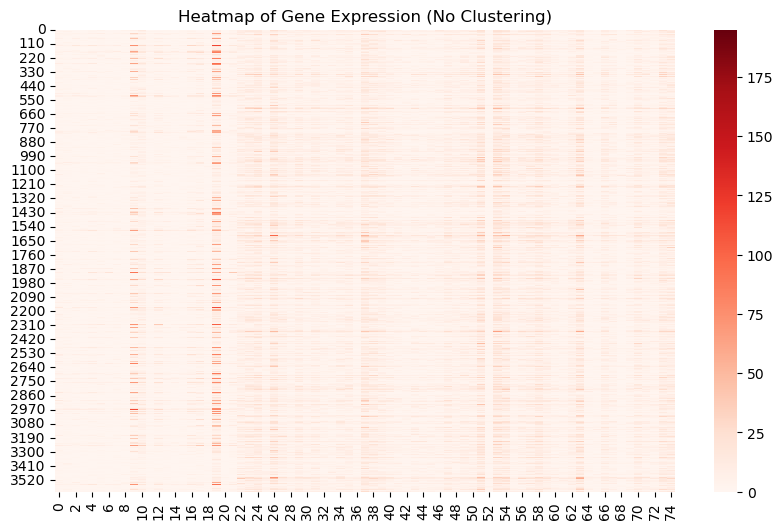

In [4]:
adata = adata[:, :-5]

# This will modify the original AnnData object to exclude the last 5 columns
data_matrix = adata.X

# Create a heatmap using seaborn, with white to red color coding
plt.figure(figsize=(10, 6))
sns.heatmap(data_matrix, cmap="Reds", cbar=True, square=False)

# Show the heatmap
plt.title('Heatmap of Gene Expression (No Clustering)')
plt.show()

In [5]:
X = data_matrix
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_standardized = (X - X_mean) / X_std

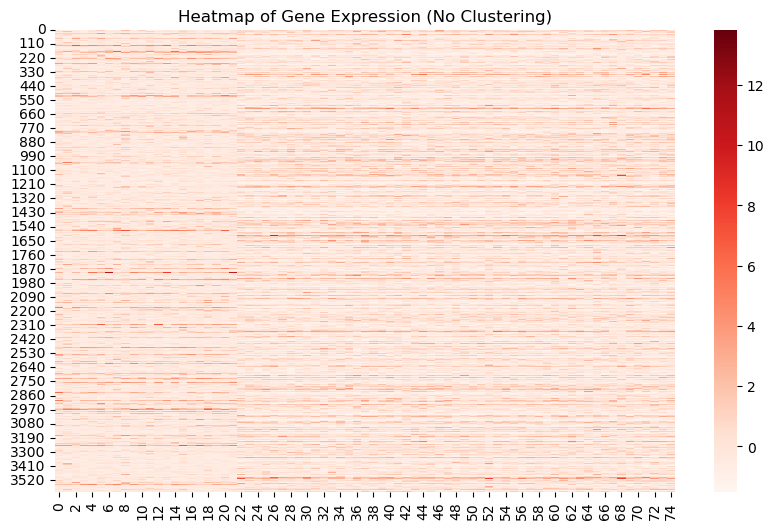

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(X_standardized, cmap="Reds", cbar=True, square=False)

# Show the heatmap
plt.title('Heatmap of Gene Expression (No Clustering)')
plt.show()

In [7]:
cov_matrix = np.cov(X_standardized, rowvar=False)

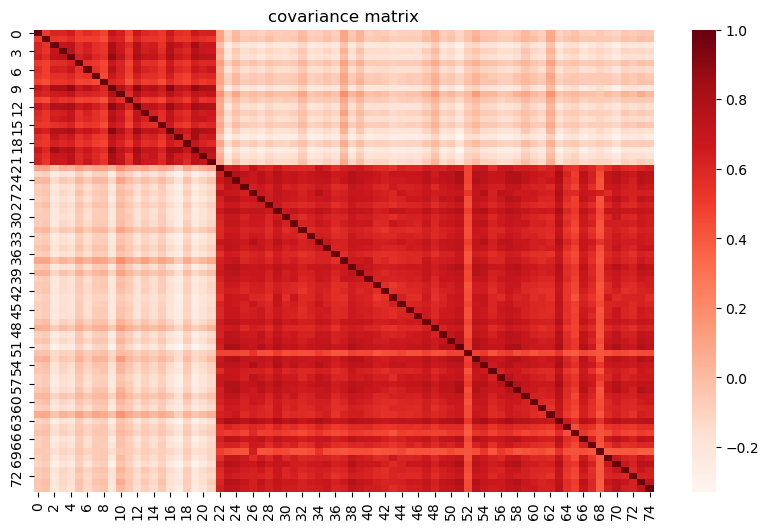

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(cov_matrix, cmap="Reds", cbar=True, square=False)

# Show the heatmap
plt.title('covariance matrix')
plt.show()

In [9]:
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

In [10]:
# Sort eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
# Choose the number of principal components (k)
k = 30  # For example, reduce to 2 dimensions

# Compute the principal components
principal_components = eigenvectors[:, :k]

print("Principal Components:\n", principal_components)

Principal Components:
 [[-0.02586355 -0.19893734  0.01012916 ...  0.03973712  0.05243462
   0.0415064 ]
 [-0.02001189 -0.18365736  0.03236738 ...  0.05805932 -0.02357231
  -0.00047632]
 [-0.05699121 -0.20860522 -0.02015463 ...  0.02250065 -0.00346797
  -0.01213466]
 ...
 [ 0.12861546 -0.01683938  0.00698731 ... -0.0590854  -0.0030248
  -0.15874848]
 [ 0.14162834 -0.02983781  0.19914745 ...  0.02031916 -0.02203516
   0.05536173]
 [ 0.13895931 -0.02112247  0.13913816 ...  0.07407755 -0.08438579
  -0.04420111]]


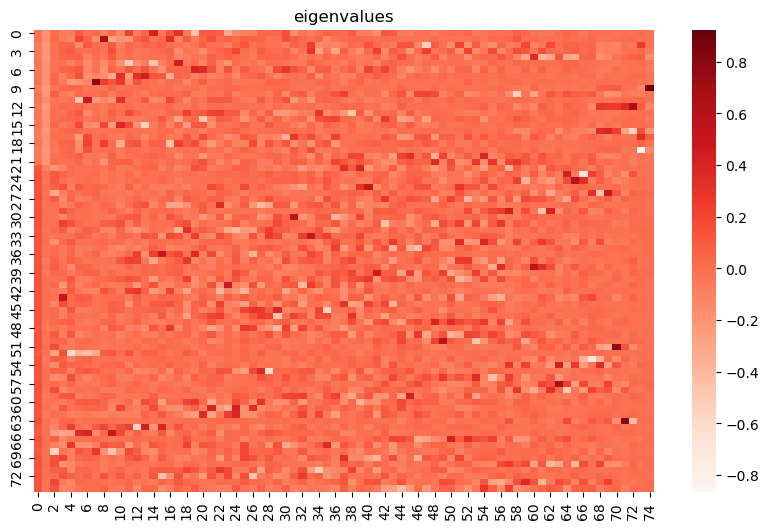

In [11]:
plt.figure(figsize=(10, 6))
sns.heatmap(eigenvectors, cmap="Reds", cbar=True, square=False)

# Show the heatmap
plt.title('eigenvalues')
plt.show()

In [12]:
X_pca = np.dot(X_standardized, principal_components)

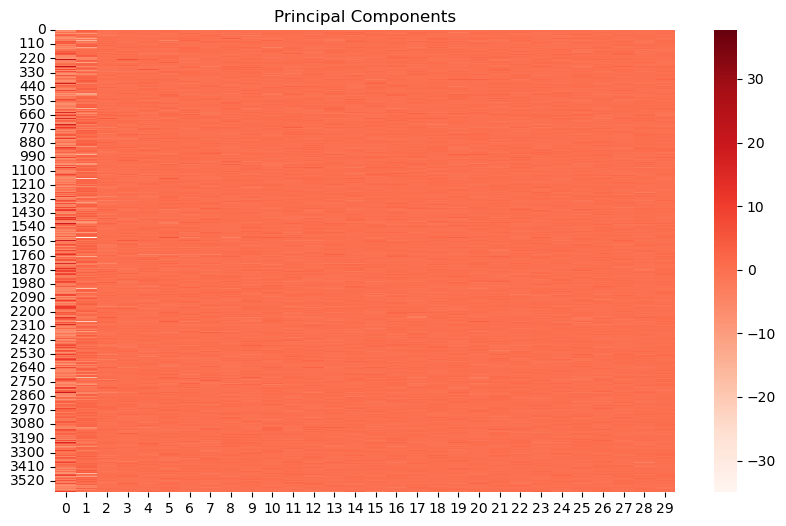

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(X_pca, cmap="Reds", cbar=True, square=False)

# Show the heatmap
plt.title('Principal Components')
plt.show()

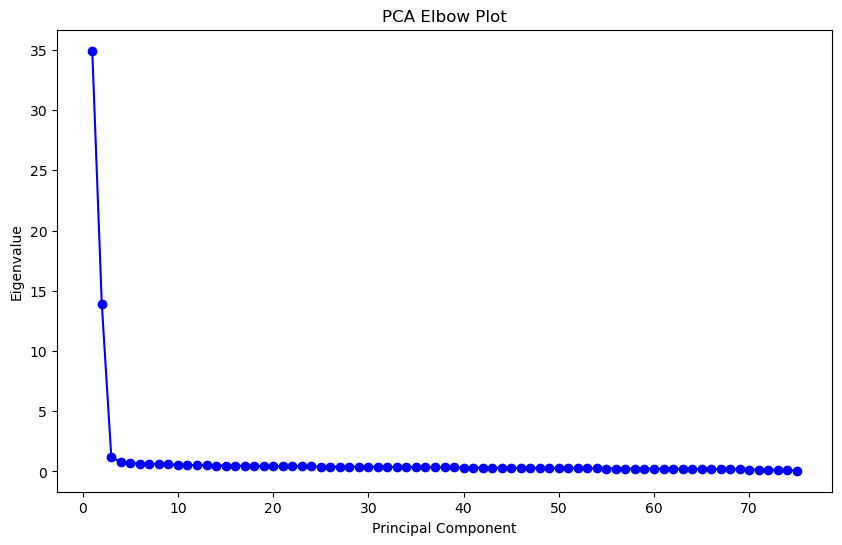

In [14]:
# PCA elbow plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('PCA Elbow Plot')
plt.show()

<center><h3>KNN from scannpy library

from this command:
```python
sc.pp.neighbors(adata,n_neighbors = 10,method='gauss')
```

In [ ]:
from sklearn.metrics import pairwise_distances
X =  X_pca[:,:2]
n_neighbors = 10
_distances = pairwise_distances(X, metric='euclidean')
# sc.pp.neighbors(adata,n_neighbors = 10,method='gauss')
Dsq = _distances.power(2)

indices = np.zeros((Dsq.shape[0], n_neighbors), dtype=int)
distances = np.zeros((Dsq.shape[0], n_neighbors), dtype=Dsq.dtype)
n_neighbors_m1 = n_neighbors - 1
for i in range(indices.shape[0]):
    neighbors = Dsq[i].nonzero()  # 'true' and 'spurious' zeros
    indices[i, 0] = i
    distances[i, 0] = 0
    # account for the fact that there might be more than n_neighbors
    # due to an approximate search
    # [the point itself was not detected as its own neighbor during the search]
    if len(neighbors[1]) > n_neighbors_m1:
        sorted_indices = np.argsort(D[i][neighbors].A1)[:n_neighbors_m1]
        indices[i, 1:] = neighbors[1][sorted_indices]
        distances[i, 1:] = D[i][
            neighbors[0][sorted_indices], neighbors[1][sorted_indices]
        ]
    else:
        indices[i, 1:] = neighbors[1]
        distances[i, 1:] = D[i][neighbors]

### Function Explanation: `_get_indices_distances_from_sparse_matrix`

The function `_get_indices_distances_from_sparse_matrix` takes a sparse distance matrix `D` and the number of nearest neighbors `n_neighbors` and returns two outputs: 
- **indices**: an array containing the indices of the nearest neighbors for each point.
- **distances**: an array containing the corresponding distances for each of the nearest neighbors.

#### Function Inputs:
- `D`: A sparse distance matrix where each row represents the distances between a particular point and all other points.
- `n_neighbors`: The number of nearest neighbors (excluding the point itself) to return for each point.

#### Step-by-Step Explanation:

1. **Initialize `indices` and `distances`**:
   - `indices`: A 2D array of zeros with dimensions `(number_of_points, n_neighbors)`. This will store the indices of the nearest neighbors.
   - `distances`: A 2D array of zeros with the same dimensions as `indices`. This will store the corresponding distances of the nearest neighbors.
   - `n_neighbors_m1`: Set to `n_neighbors - 1`. This is used for indexing neighbors, excluding the point itself.

2. **Main Loop (`for i in range(indices.shape[0])`)**:
   - Loop over each point `i`.
   - **Find neighbors**:
     - Use `D[i].nonzero()` to get the indices of non-zero elements (i.e., the indices of neighbors for point `i`).
     - Set the first entry of `indices` for point `i` to `i` itself and the first entry of `distances` for point `i` to `0` (since the distance to itself is zero).
     
3. **Handling the neighbors**:
   - **Case 1**: If there are more neighbors than needed (`len(neighbors[1]) > n_neighbors_m1`):
     - **Sort and select closest neighbors**: Sort the neighbors by their distance and select the `n_neighbors - 1` closest ones.
     - Store the indices and distances of these sorted neighbors in the `indices` and `distances` arrays.
   
   - **Case 2**: If the number of neighbors is less than or equal to `n_neighbors - 1`:
     - Directly assign the neighbors' indices and distances to the `indices` and `distances` arrays.

4. **Return the results**:
   - Return the two arrays `indices` (containing the nearest neighbors' indices) and `distances` (containing the distances to those neighbors).

#### Key Points:
- The function ensures that the point itself is included in the nearest neighbors list (with distance 0).
- It handles cases where there are more neighbors than required by selecting the closest ones.
- The function works with sparse matrices where some distances might be zero due to sparsity.


In [41]:
from sklearn.metrics import pairwise_distances
_distances = pairwise_distances(X_pca, metric='euclidean')
# sc.pp.neighbors(adata,n_neighbors = 10,method='gauss')
Dsq = np.power(X_pca,2)

In [46]:
k=80
neighbors = np.argsort(Dsq, axis=1)[:, 1:k+1]

In [47]:
weights_matrix = np.zeros(Dsq.shape)

# Set the weights to 1 for the k-nearest neighbors
for i in range(weights_matrix.shape[0]):
    weights_matrix[i, neighbors[i]] = 1
weights_matrix

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

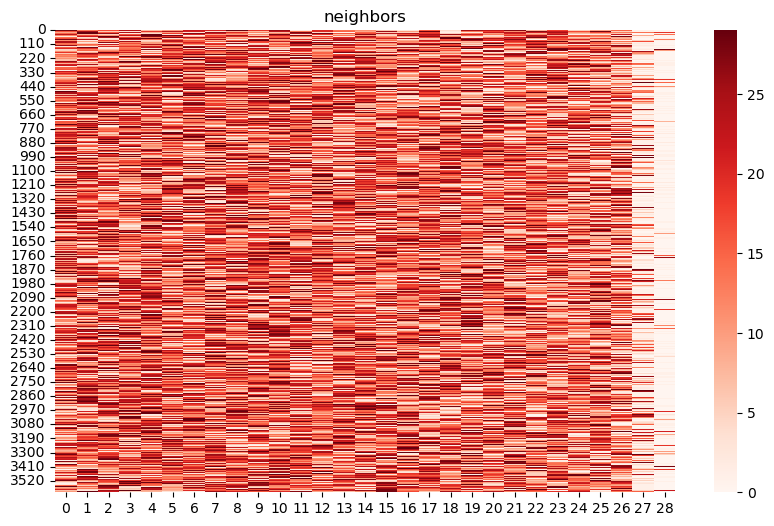

In [50]:
plt.figure(figsize=(10, 6))
sns.heatmap(neighbors, cmap="Reds", cbar=True, square=False)

# Show the heatmap
plt.title('neighbors')
plt.show()

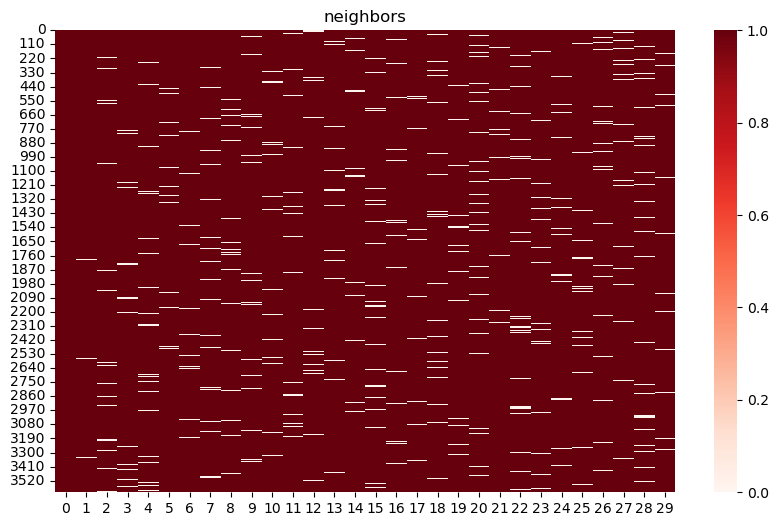

In [49]:
plt.figure(figsize=(10, 6))
sns.heatmap(weights_matrix, cmap="Reds", cbar=True, square=False)

# Show the heatmap
plt.title('neighbors')
plt.show()

In [51]:
adata

View of AnnData object with n_obs × n_vars = 3611 × 75
    obsm: 'spatial'

In [52]:
sc.pp.pca(adata, n_comps=2)
sc.pp.neighbors(adata,n_neighbors = 10,method='gauss')

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


In [53]:
adata

AnnData object with n_obs × n_vars = 3611 × 75
    uns: 'pca', 'neighbors'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [54]:
adata.obsp['distances']

<3611x3611 sparse matrix of type '<class 'numpy.float64'>'
	with 32499 stored elements in Compressed Sparse Row format>